# Chapter 14: Deep Computer Vision Using Convolutional Neural Networks

### Ensure GPU Env is working correctly

In [1]:
import tensorflow as tf
import os
from tensorflow import keras

In [2]:
tf.__version__

'2.6.0'

In [3]:
keras.__version__

'2.6.0'

In [4]:
print("Num of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num of GPUs Available:  1


### Additional Libraries

In [5]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## What is a convolution?

A convolution is an operations in mathematics where we would use two functions and essentially modify the shape of one function using the other. Say we have function *f* and function *g*, the result of a convolution of *f* on *g* would yield (f * g) and it is done by taking the integral of the product of the two functions. One of the functions is reversed and shifted and the integral evaluates the value shifts, which yields our convolution. An example of a convolution is shown below: 

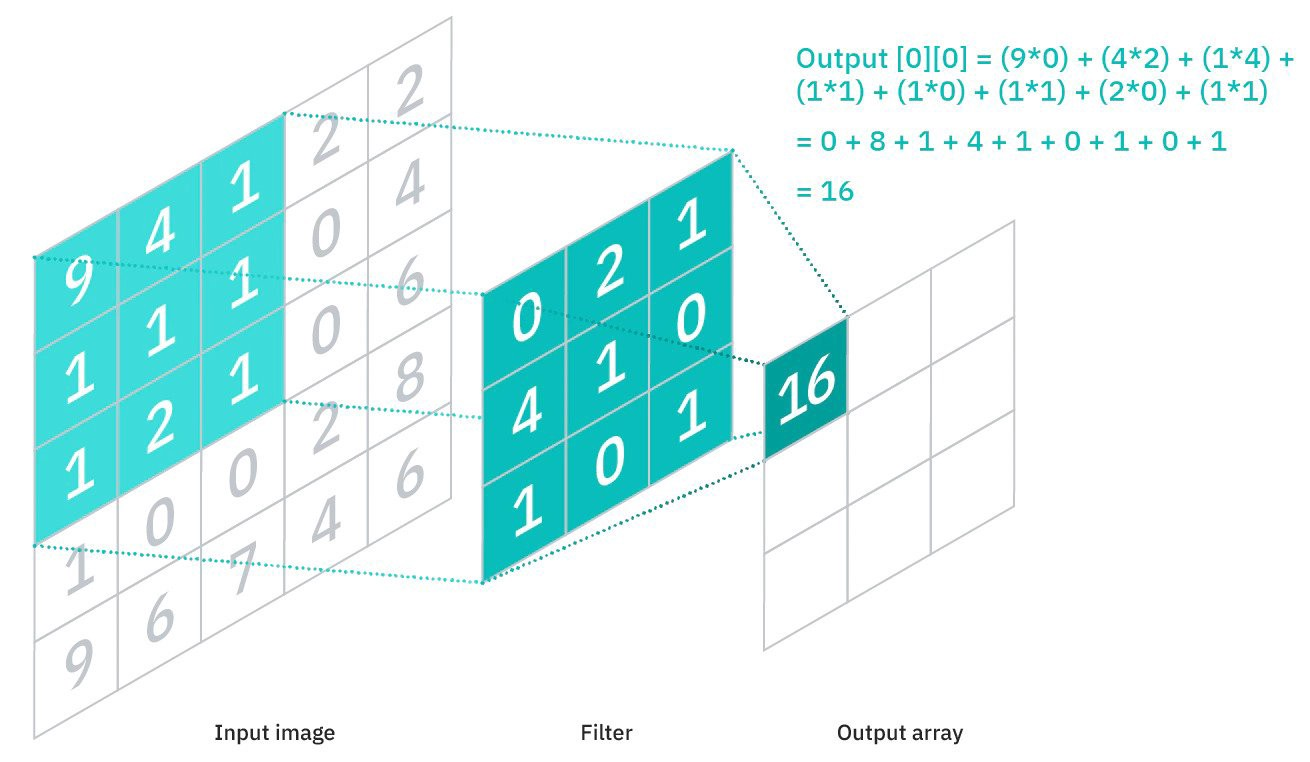

In the above image, the input image would represent function *f* and the filter would be *g* and then the output array is (f*g) (missing a bit of details in between. The below image also shows another emample of a convolution between two functions:

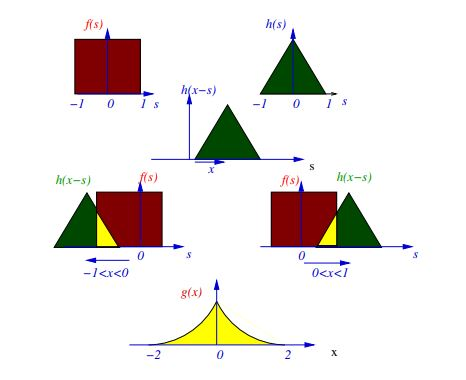

## Convolutions for vertical and horizontal aspects of an image

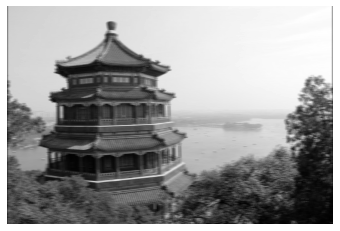

In [6]:
from sklearn.datasets import load_sample_image

jpeg1 = load_sample_image("china.jpg") / 255
jpeg2 = load_sample_image("flower.jpg") / 255
images = np.array([jpeg1, jpeg2])
batch_size, height, width, channels = images.shape

# now to create 2 filters 
filters = np.zeros(shape = (7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # for vertical lines 
filters[3, :, :, 1] = 1 # for horizontal lines

output = tf.nn.conv2d(images, filters, strides=1, padding= "SAME")

plt.imshow(output[0, :, :, 1], cmap="gray") # first image map for first image
plt.axis("off")
plt.show()

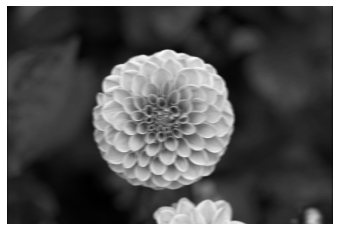

In [7]:
plt.imshow(output[1, :, :, 1], cmap="gray") # first image map for second image
plt.axis("off")
plt.show()

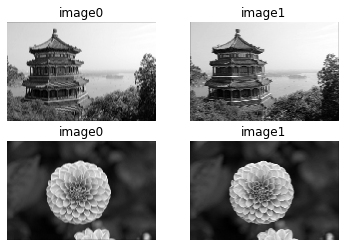

In [8]:
# now for both vertical and horizontal for pictures
def plot_image(image, title):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.title(title)
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

for images_group in (0, 1):
    for map_index in (0, 1):
        plt.subplot(2, 2, images_group * 2 + map_index + 1)
        plot_image(output[images_group, :, :, map_index], title=f'image{map_index}')
        
plt.show()

In [9]:
# for cropping images
def crop(images):
    return images[150:220, 130:250]

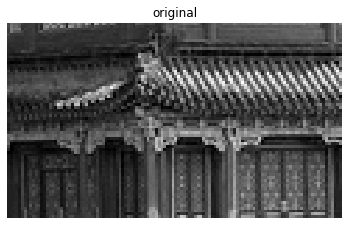

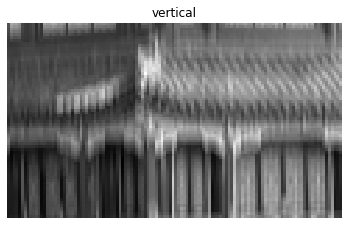

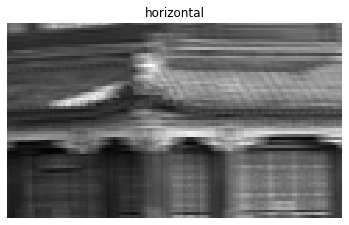

In [10]:
#Original Image
plot_image(crop(images[0, :, :, 0]), title="original")
plt.show()
plot_image(crop(output[0, :, :, 0]), title="vertical")
plt.show()
plot_image(crop(output[0, :, :, 1]), title="horizontal")
plt.show()

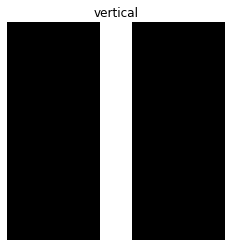

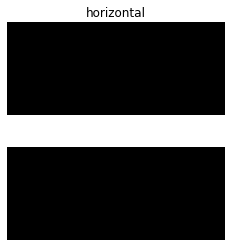

In [11]:
plot_image(filters[:, :, 0, 0], title='vertical')
plt.show()
plot_image(filters[:, :, 0, 1], title='horizontal')
plt.show()

## Convolutional Layer

In [12]:
conv_layer = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1, padding="SAME", 
                                activation="relu", input_shape=output.shape)

In [13]:
# now pass in two testing images
conv_outputs = conv_layer(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since `padding="SAME"` and `strides=1`, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

Since the filters are initialized randomly, they'll initially detect random patterns. Let's take a look at the 2 output features maps for each image:

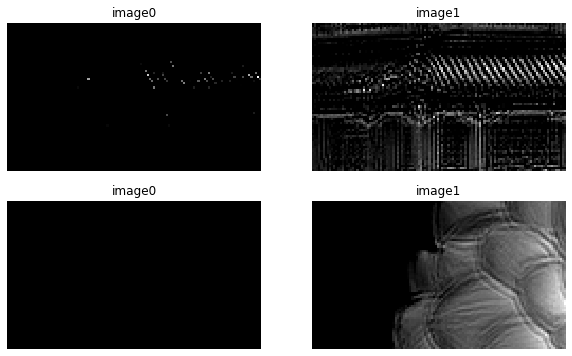

In [14]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]), title=f'image{feature_map_index}')
plt.show()

In the result above, the filters were initialized randomly. Additionally, we can set the filters to be ones we want to manually define and set the associated biases to zeros.

In [15]:
conv_layer.set_weights([filters, np.zeros(2)])

In [16]:
conv_outputs = conv_layer(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

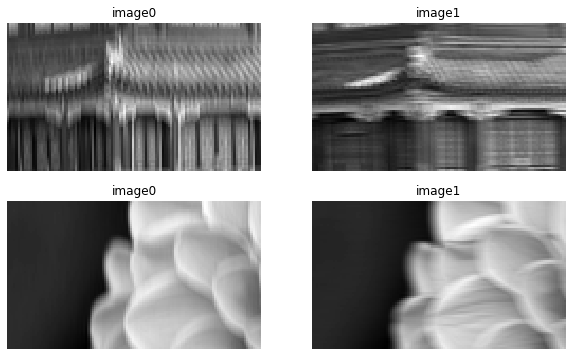

In [17]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]), title=f'image{feature_map_index}')
plt.show()

## Difference between VALID & SAME Padding 

In [18]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [19]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [20]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using "SAME" padding is equivalent to padding manually using manual_same_padding() then using "VALID" padding (confusingly, "VALID" padding means no padding at all):

In [21]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

## Pooling Layer

### Max Pooling

In [22]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [23]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

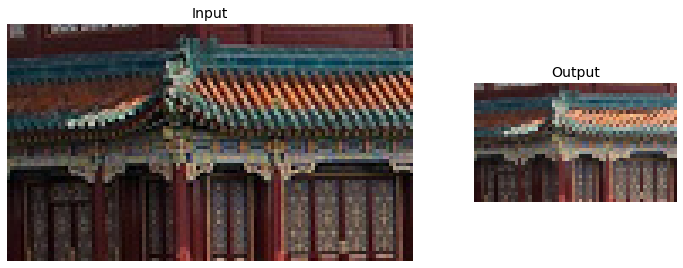

In [24]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### Depth-wise Pooling 

In [25]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [26]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [27]:
# Optionally, there is also the Lambda layer
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

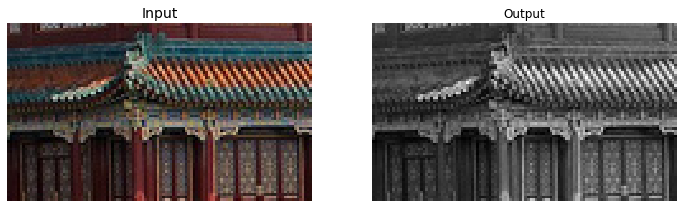

In [28]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plot_image(depth_output[0, ..., 0], title ='Output')  # plot the output for the 1st image
plt.axis("off")
plt.show()

### Average Pooling

In [29]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [30]:
output_avg = avg_pool(cropped_images)

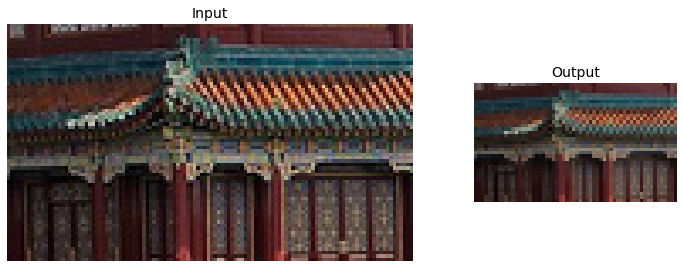

In [31]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### Global Average Pooling

In [32]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

In [33]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

## CNN On MNIST Fashion Dataset

In [34]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [35]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [36]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 30s 15ms/step - loss: 0.7009 - accuracy: 0.7566 - val_loss: 0.3570 - val_accuracy: 0.8678
Epoch 2/10
1719/1719 [==============================] - 25s 15ms/step - loss: 0.4147 - accuracy: 0.8623 - val_loss: 0.3071 - val_accuracy: 0.8870
Epoch 3/10
1719/1719 [==============================] - 25s 15ms/step - loss: 0.3558 - accuracy: 0.8789 - val_loss: 0.3039 - val_accuracy: 0.8858
Epoch 4/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3297 - accuracy: 0.8878 - val_loss: 0.2974 - val_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3046 - accuracy: 0.8968 - val_loss: 0.2915 - val_accuracy: 0.8960
Epoch 6/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2902 - accuracy: 0.9013 - val_loss: 0.2824 - val_accuracy: 0.8984
Epoch 7/10
1719/1719 [==============================] - 25s 15ms/step - loss: 0.2752 - accuracy: 0.9073 - val_loss: 0.2933 -

## ResNet-34 Architecture

In [37]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [38]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

## Pretrained Model

In [40]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

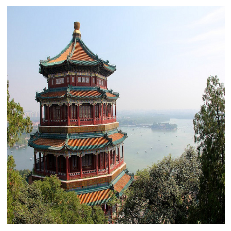

In [41]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


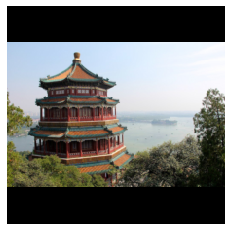

In [42]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

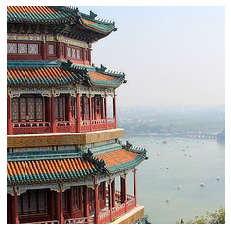

In [43]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

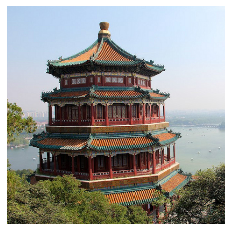

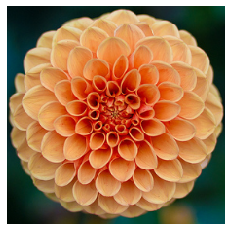

In [44]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [45]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [46]:
Y_proba.shape

(2, 1000)

In [47]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       43.42%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.67%

Image #1
  n04522168 - vase         53.90%
  n07930864 - cup          9.53%
  n11939491 - daisy        4.96%



## Using a pretrained model for transfer learning

In [48]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [49]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [50]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [51]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [52]:
n_classes = info.features["label"].num_classes

In [53]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [54]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

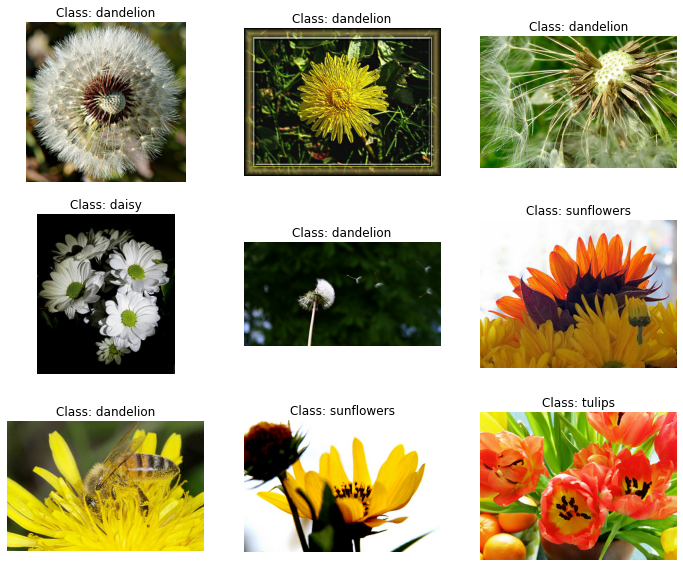

In [55]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [56]:
# preprocessing function
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [57]:
# fancier preprop
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

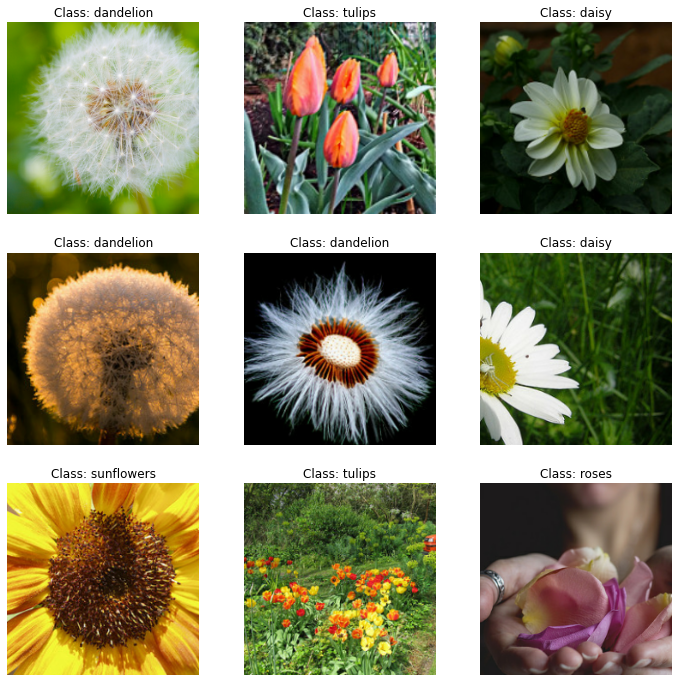

In [58]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

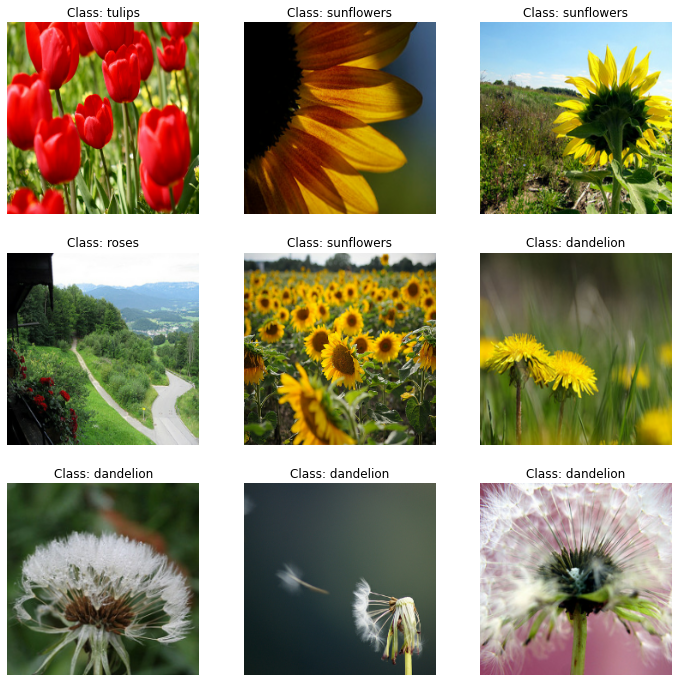

In [59]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [60]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [61]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_44
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_45
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_46
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [62]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 11s 91ms/step - loss: 1.2089 - accuracy: 0.8012 - val_loss: 1.0554 - val_accuracy: 0.8529
Epoch 2/5
86/86 [==============================] - 8s 90ms/step - loss: 0.5866 - accuracy: 0.8939 - val_loss: 0.8071 - val_accuracy: 0.8493
Epoch 3/5
86/86 [==============================] - 8s 92ms/step - loss: 0.2976 - accuracy: 0.9288 - val_loss: 0.7442 - val_accuracy: 0.8640
Epoch 4/5
86/86 [==============================] - 8s 91ms/step - loss: 0.2419 - accuracy: 0.9386 - val_loss: 0.6521 - val_accuracy: 0.8603
Epoch 5/5
86/86 [==============================] - 7s 85ms/step - loss: 0.2048 - accuracy: 0.9455 - val_loss: 0.7624 - val_accuracy: 0.8603


In [63]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 41s 404ms/step - loss: 0.3461 - accuracy: 0.8877 - val_loss: 0.3740 - val_accuracy: 0.8824
Epoch 2/40
86/86 [==============================] - 34s 399ms/step - loss: 0.1118 - accuracy: 0.9626 - val_loss: 0.3068 - val_accuracy: 0.9173
Epoch 3/40
86/86 [==============================] - 34s 399ms/step - loss: 0.0684 - accuracy: 0.9793 - val_loss: 0.2938 - val_accuracy: 0.9246
Epoch 4/40
86/86 [==============================] - 34s 398ms/step - loss: 0.0485 - accuracy: 0.9840 - val_loss: 0.2921 - val_accuracy: 0.9246
Epoch 5/40
86/86 [==============================] - 34s 392ms/step - loss: 0.0390 - accuracy: 0.9906 - val_loss: 0.2618 - val_accuracy: 0.9228
Epoch 6/40
86/86 [==============================] - 34s 400ms/step - loss: 0.0298 - accuracy: 0.9920 - val_loss: 0.2892 - val_accuracy: 0.9265
Epoch 7/40
86/86 [==============================] - 34s 399ms/step - loss: 0.0284 - accuracy: 0.9913 - val_loss: 0.2827 - val_accuracy: 0.9393

## Classification and Localization

In [64]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [65]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [66]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 4s 372ms/step - loss: 1.4084 - dense_5_loss: 1.6303 - dense_6_loss: 0.5209 - dense_5_accuracy: 0.2562 - dense_6_accuracy: 0.2313
Epoch 2/2
5/5 [==============================] - 2s 373ms/step - loss: 1.3393 - dense_5_loss: 1.5770 - dense_6_loss: 0.3881 - dense_5_accuracy: 0.2688 - dense_6_accuracy: 0.2625


## Mean Average Precision (mAP)

In [67]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

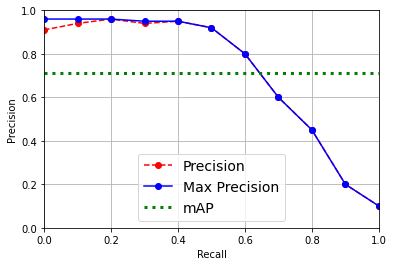

In [68]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

In [69]:
# Transposing the convolutions
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

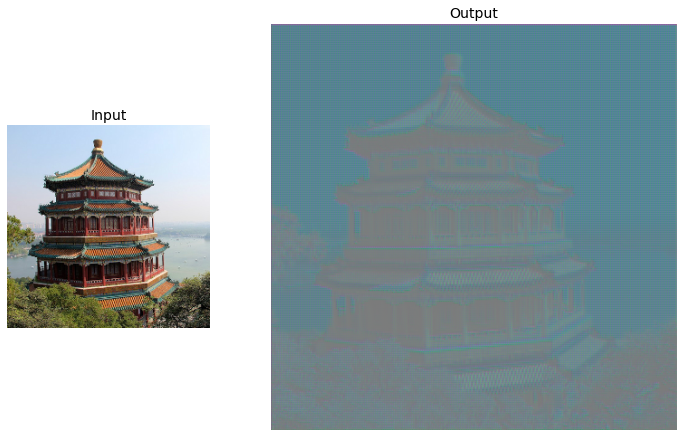

In [70]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [71]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [72]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

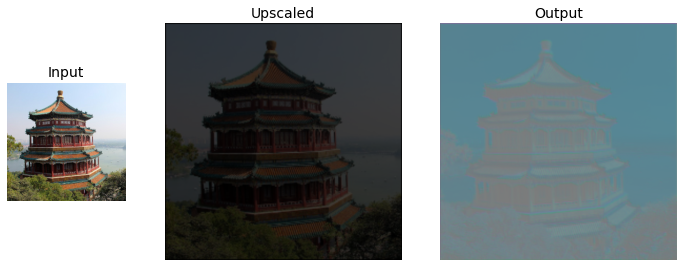

In [73]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

In [74]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True

# End of Chapter Exercises

1. What are the advantages of a CNN over a fully connected DNN for image classification?
2. Consider a CNN composed of three convolutional layers, each with 3 × 3 kernels,
a stride of 2, and "same" padding. The lowest layer outputs 100 feature maps, the
middle one outputs 200, and the top one outputs 400. The input images are RGB
images of 200 × 300 pixels.
What is the total number of parameters in the CNN? If we are using 32-bit floats,
at least how much RAM will this network require when making a prediction for a
single instance? What about when training on a mini-batch of 50 images?
3. If your GPU runs out of memory while training a CNN, what are five things you
could try to solve the problem?
4. Why would you want to add a max pooling layer rather than a convolutional
layer with the same stride?
5. When would you want to add a local response normalization layer?
6. Can you name the main innovations in AlexNet, compared to LeNet-5? What
about the main innovations in GoogLeNet, ResNet, SENet, and Xception?
7. What is a fully convolutional network? How can you convert a dense layer into a
convolutional layer?
8. What is the main technical difficulty of semantic segmentation?
9. Build your own CNN from scratch and try to achieve the highest possible accu‐
racy on MNIST.
10. Use transfer learning for large image classification, going through these steps:
a. Create a training set containing at least 100 images per class. For example, you
could classify your own pictures based on the location (beach, mountain, city,
etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow
Datasets).
b. Split it into a training set, a validation set, and a test set.
c. Build the input pipeline, including the appropriate preprocessing operations,
and optionally add data augmentation.
d. Fine-tune a pretrained model on this dataset.
11. Go through TensorFlow’s Style Transfer tutorial. It is a fun way to generate art
using Deep Learning.

***1. What are the advantages of a CNN over a fully connected DNN for image classification?***
A: DNN can break down large with larger images in datasets. If it is a fully connected layers, a 10,000 pixel image (100x100) with 1000 neurons can have 10 million connections (10,000 * 1000). CNNs also have 2D layers, so there is not a need to flatten to 1D and it will be easier to match neurons with corresponding inputs. 

***2. Consider a CNN composed of three convolutional layers, each with 3 × 3 kernels,
a stride of 2, and "same" padding. The lowest layer outputs 100 feature maps, the
middle one outputs 200, and the top one outputs 400. The input images are RGB
images of 200 × 300 pixels.
What is the total number of parameters in the CNN? If we are using 32-bit floats,
at least how much RAM will this network require when making a prediction for a
single instance? What about when training on a mini-batch of 50 images?***

A: Let us do the math for this: 3X3 for kernels, 3 input channels because the input images are RGB (This equates to 3x3x3 + Bias term) and 100 feature maps for the lowest layer. With this we have 28 parameters per feature map (28 x 100 = 2800). Second layer: 200 feature maps, and then 100 from the previous layer. But, the previous layer feature maps are the input for the 3 x 3 kernel with the bias term. So all in all we have 200 for the feature maps and 100x3x3 + 1 for the weights or 901 x 200 = 180, 200 parameters for layer 2. For layer three we have 200 feature maps from the previous layer multiplied by the 3 x 3 kernel + bias term. and then we have 400 feature maps: (200x3x3+1)x(400) = 720,400. So all in all we have 2800 + 180,200 + 720,400 = 903,400.

For total RAM.. this will be a challenge. If we are using padding two, for each layer we divide the dimensions by 2 so 200x300 becomes 100x150, 50x75 and then 25x38 and thern we have our feature maps for each layer. We also have a 32-bit floating number, which is 4 bytes. Now let's start our calculations. We will have 100x150x100x4 = 6MB for first layer, 50x75x200x4 = 3MB and 25x38x400x4 = 1.5MB. Then we have our parameters which are each 4 bytes. So thats is 4x903,400 = 3.6MB (Roughly) So we have 6+3+1.5+3.6 = 14.1 MB.

If we extend the above further to include a minibatch... Well this is now 50X14.5 = 725MB + our input images. We know that our input images are 4bytes with a 200x300 pixel size and RGB scheme (3). So we end up with 4x200x300x3 = .72MB but now multiply that by 50 to yield 36MB So we end up at around 725+36 = 761MB.

***3. If your GPU runs out of memory while training a CNN, what are five things you
could try to solve the problem?***

A:
1) Reducing batch size
2) Removing Layers
3) Changing floating point to 16bit
4) Use multiple devices for the CNN or distributing across multiple (Assuming you have multiple)
5) Use a higher stride so it makes the layers smaller in subsequent layers.

***4. Why would you want to add a max pooling layer rather than a convolutional
layer with the same stride?***

A: Simply because max pooling layers have no parameters. It simply select the max element in the feature map. A layer may have tons of parameters therefore increasing computing power requirements.

***5. When would you want to add a local response normalization layer?***

A: Local response normalization layers are good for ensuring previous layers learn a wide variety of features. So more broad networks are typically early layers or lower layers that are very general when learning the images they are training. So that is where you would want to add one. 

***6. Can you name the main innovations in AlexNet, compared to LeNet-5? What
about the main innovations in GoogLeNet, ResNet, SENet, and Xception?***

A: AlexNet: Very large and deep network with lots of stacked convolutional layers and stacked pooling layers on top of those convolutional layers. 

GoogLeNet: Inception Modules

ResNet: Skip Connections

SENet: SE blocks after inception networks (These are 2-layer dense networks)

Xception: Depthwise seperable convolutional layers

***7. What is a fully convolutional network? How can you convert a dense layer into a
convolutional layer?***

A: A fully convolutional network is a neural network composed of convolutional and pooling layers only. The simplest way to convert a dense layer to a convolutional layer is to replace that layer with a convolutional layer with a kernel size that is the same as the input size. This is assuming this is a CNN with dense layers and to change those dense layers to convoltuional layers. 

***8. What is the main technical difficulty of semantic segmentation?***

A: First, semantic segmentation is the process of trying to assign labels to every pixel in an image. The difficulty with this process is that when images go through a regular CNN, they gradually lose their spatial resoltuion (layers with strides greater than 1 are the culprit). This issue can cause a truck to be categorized in the middle left of an image, but it may not be precise and it may only categorized 2/3 of where the truck actually resides in the image.

In [1]:
# Question 9
'''9. Build your own CNN from scratch and try to achieve the highest possible accu‐
racy on MNIST.'''

import tensorflow as tf
import os
from tensorflow import keras
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full/ 255. # Pixel division 
X_test = X_test/ 255.
X_val, X_train = X_train_full[:5000], X_train_full[5000:]
y_val, y_train = y_train_full[:5000], y_train_full[5000:]

# Make dataset into 2D space using np.newaxis
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [3]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 33s 10ms/step - loss: 0.1987 - accuracy: 0.9402 - val_loss: 0.0542 - val_accuracy: 0.9840
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0819 - accuracy: 0.9749 - val_loss: 0.0440 - val_accuracy: 0.9866
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0626 - accuracy: 0.9809 - val_loss: 0.0431 - val_accuracy: 0.9886
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0507 - accuracy: 0.9844 - val_loss: 0.0462 - val_accuracy: 0.9892
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0445 - accuracy: 0.9860 - val_loss: 0.0393 - val_accuracy: 0.9902
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0363 - accuracy: 0.9880 - val_loss: 0.0373 - val_accuracy: 0.9890
Epoch 7/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0322 - accuracy: 0.9897 - val_loss: 0.0435 - val_

[0.03207363933324814, 0.9919000267982483]

Not bad, now let's try with ensemble learning with say 10 models of CNNs:

In [33]:
models = []

for i in range(10):
    model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(), # inclusion of batch normalization
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")])
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
    models.append(model)

In [34]:
models

We can also augment the images using the ImageDataGenerator in TensorFlow:

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10,  zoom_range = 0.1,  width_shift_range=0.1,  height_shift_range=0.1)
datagen.fit(X_train)

In [36]:
X_train.shape

(55000, 28, 28, 1)

And to top it off, let's add a learning rate decelerator with exponential decay as well:

In [37]:
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                patience=3, 
                                verbose=1, 
                                factor=0.25, 
                                min_lr=1e-7)

In [39]:
history = [0] * 10

for i in range(10):
    history[i] = models[i].fit_generator(datagen.flow(X_train, y_train, batch_size = 64), 
                                             epochs = 15, validation_data = (X_val, y_val), callbacks = [reduce_lr])
    print("CNN : {} Maximum Train Accuracy : {} Maximum Validation Accuracy : {}".format(i+1, max(history[i].history['accuracy']), max(history[i].history['val_accuracy'])))

Epoch 1/15
860/860 [==============================] - 13s 15ms/step - loss: 0.0798 - accuracy: 0.9783 - val_loss: 0.0330 - val_accuracy: 0.9910
Epoch 2/15
860/860 [==============================] - 13s 16ms/step - loss: 0.0755 - accuracy: 0.9797 - val_loss: 0.0305 - val_accuracy: 0.9934
Epoch 3/15
860/860 [==============================] - 14s 16ms/step - loss: 0.0757 - accuracy: 0.9798 - val_loss: 0.0309 - val_accuracy: 0.9924
Epoch 4/15
860/860 [==============================] - 13s 16ms/step - loss: 0.0711 - accuracy: 0.9808 - val_loss: 0.0240 - val_accuracy: 0.9942
Epoch 5/15
860/860 [==============================] - 14s 16ms/step - loss: 0.0667 - accuracy: 0.9823 - val_loss: 0.0217 - val_accuracy: 0.9940
Epoch 6/15
860/860 [==============================] - 14s 16ms/step - loss: 0.0628 - accuracy: 0.9825 - val_loss: 0.0225 - val_accuracy: 0.9940
Epoch 7/15
860/860 [==============================] - 14s 16ms/step - loss: 0.0659 - accuracy: 0.9820 - val_loss: 0.0256 - val_accuracy:


Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 8/15
860/860 [==============================] - 14s 16ms/step - loss: 0.0477 - accuracy: 0.9871 - val_loss: 0.0190 - val_accuracy: 0.9952
Epoch 9/15
860/860 [==============================] - 14s 16ms/step - loss: 0.0381 - accuracy: 0.9891 - val_loss: 0.0221 - val_accuracy: 0.9942
Epoch 10/15
860/860 [==============================] - 14s 16ms/step - loss: 0.0387 - accuracy: 0.9887 - val_loss: 0.0200 - val_accuracy: 0.9946
Epoch 11/15
860/860 [==============================] - 14s 16ms/step - loss: 0.0377 - accuracy: 0.9891 - val_loss: 0.0195 - val_accuracy: 0.9950

Epoch 00011: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 12/15
860/860 [==============================] - 13s 16ms/step - loss: 0.0320 - accuracy: 0.9909 - val_loss: 0.0187 - val_accuracy: 0.9948
Epoch 13/15
860/860 [==============================] - 13s 16ms/step - loss: 0.0295 - accuracy: 0.9916 - val_loss: 0

860/860 [==============================] - 14s 16ms/step - loss: 0.0260 - accuracy: 0.9928 - val_loss: 0.0134 - val_accuracy: 0.9966
Epoch 15/15
860/860 [==============================] - 14s 16ms/step - loss: 0.0254 - accuracy: 0.9926 - val_loss: 0.0134 - val_accuracy: 0.9962
CNN : 7 Maximum Train Accuracy : 0.9927636384963989 Maximum Validation Accuracy : 0.9965999722480774
Epoch 1/15
860/860 [==============================] - 16s 17ms/step - loss: 0.3801 - accuracy: 0.8807 - val_loss: 0.0462 - val_accuracy: 0.9864
Epoch 2/15
860/860 [==============================] - 15s 17ms/step - loss: 0.1328 - accuracy: 0.9605 - val_loss: 0.0404 - val_accuracy: 0.9890
Epoch 3/15
860/860 [==============================] - 15s 17ms/step - loss: 0.1000 - accuracy: 0.9718 - val_loss: 0.0322 - val_accuracy: 0.9918
Epoch 4/15
860/860 [==============================] - 14s 17ms/step - loss: 0.0876 - accuracy: 0.9745 - val_loss: 0.0446 - val_accuracy: 0.9866
Epoch 5/15
860/860 [=========================

In [41]:
for i in range(10):
    models[i].evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0151 - accuracy: 0.9958


In [2]:
# Question 10
'''10. Use transfer learning for large image classification, going through these steps:
a. Create a training set containing at least 100 images per class. For example, you
could classify your own pictures based on the location (beach, mountain, city,
etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow
Datasets).
b. Split it into a training set, a validation set, and a test set.
c. Build the input pipeline, including the appropriate preprocessing operations,
and optionally add data augmentation.
d. Fine-tune a pretrained model on this dataset.'''

import tensorflow as tf
import os
from tensorflow import keras
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## a. Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city,etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets).

In [20]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("cats_vs_dogs", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to C:\Users\User\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.


In [21]:
info.splits

{Split('train'): <SplitInfo num_examples=23262, num_shards=8>}

In [23]:
class_names = info.features["label"].names
class_names

['cat', 'dog']

In [24]:
n_classes = info.features["label"].num_classes
n_classes

2

In [35]:
dataset_size = info.splits["train"].num_examples
dataset_size

23262

## b. Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets).

In [25]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

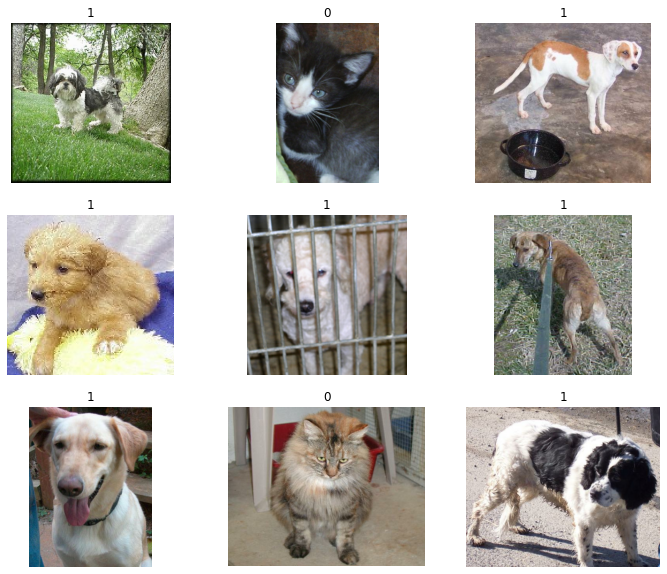

In [104]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

plt.show()

We note that 1 is dogs and 0 is cats

## c. Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation.

In [27]:
# preprocessing function
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [36]:
# fancier preprocessing 
from functools import partial
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 64
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
val_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

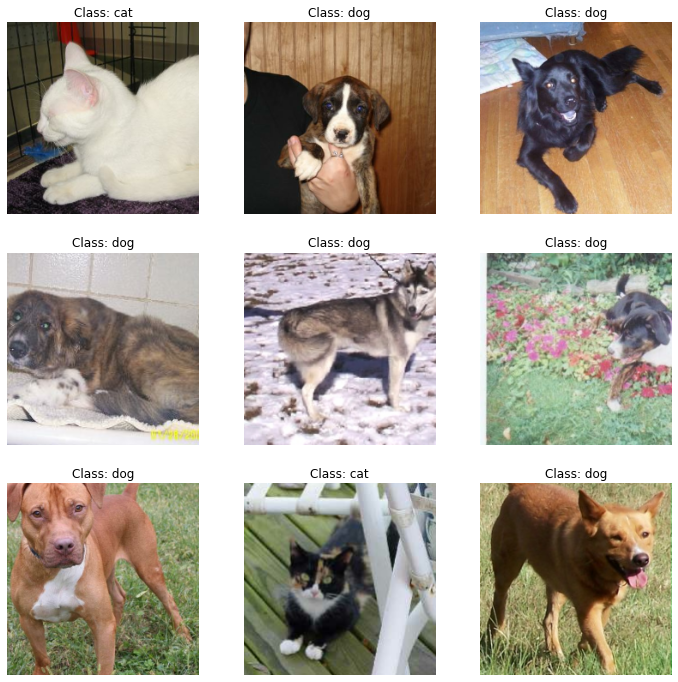

In [37]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [41]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [42]:
for index, layers in enumerate(base_model.layers):
    print(index, layers.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_8
13 block2_pool
14 batch_normalization_8
15 add_24
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_9
23 block3_pool
24 batch_normalization_9
25 add_25
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_10
33 block4_pool
34 batch_normalization_10
35 add_26
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_27
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_

In [45]:
for layer in base_model.layers:
    layer.trainable = False
    
optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.95, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=["accuracy"])
history = model.fit(train_set,
                   steps_per_epoch=int(0.75 * dataset_size /  batch_size),
                   validation_data=val_set,
                   validation_steps=int(0.15 * dataset_size / batch_size),
                   epochs=10)

Epoch 1/10
272/272 [==============================] - 67s 184ms/step - loss: 0.0857 - accuracy: 0.9862 - val_loss: 0.0786 - val_accuracy: 0.9878
Epoch 2/10
272/272 [==============================] - 49s 180ms/step - loss: 0.0413 - accuracy: 0.9912 - val_loss: 0.0691 - val_accuracy: 0.9893
Epoch 3/10
272/272 [==============================] - 49s 180ms/step - loss: 0.0393 - accuracy: 0.9916 - val_loss: 0.0592 - val_accuracy: 0.9890
Epoch 4/10
272/272 [==============================] - 49s 179ms/step - loss: 0.0317 - accuracy: 0.9921 - val_loss: 0.0561 - val_accuracy: 0.9896
Epoch 5/10
272/272 [==============================] - 50s 183ms/step - loss: 0.0296 - accuracy: 0.9922 - val_loss: 0.0531 - val_accuracy: 0.9890
Epoch 6/10
272/272 [==============================] - 49s 182ms/step - loss: 0.0252 - accuracy: 0.9929 - val_loss: 0.0519 - val_accuracy: 0.9887
Epoch 7/10
272/272 [==============================] - 51s 187ms/step - loss: 0.0236 - accuracy: 0.9937 - val_loss: 0.0499 - val_ac

## d. Fine-tune a pretrained model on this dataset.

In [50]:
for layer in base_model.layers:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(learning_rate=0.005, momentum=0.95, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=["accuracy"])
history = model.fit(train_set,
                   steps_per_epoch=int(0.75 * dataset_size /  batch_size),
                   validation_data=val_set,
                   validation_steps=int(0.15 * dataset_size / batch_size),
                   epochs=5)

Epoch 1/5
272/272 [==============================] - 207s 753ms/step - loss: 0.0155 - accuracy: 0.9941 - val_loss: 0.0367 - val_accuracy: 0.9876
Epoch 2/5
272/272 [==============================] - 205s 754ms/step - loss: 0.0143 - accuracy: 0.9945 - val_loss: 0.0365 - val_accuracy: 0.9878
Epoch 3/5
272/272 [==============================] - 225s 827ms/step - loss: 0.0140 - accuracy: 0.9951 - val_loss: 0.0362 - val_accuracy: 0.9878
Epoch 4/5
272/272 [==============================] - 229s 841ms/step - loss: 0.0127 - accuracy: 0.9954 - val_loss: 0.0362 - val_accuracy: 0.9878
Epoch 5/5
272/272 [==============================] - 228s 837ms/step - loss: 0.0124 - accuracy: 0.9958 - val_loss: 0.0363 - val_accuracy: 0.9881


In [101]:
model.save('model.h5')

D:\Anaconda\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [118]:
from keras.models import load_model

model = load_model('model.h5')

Now to test on an image

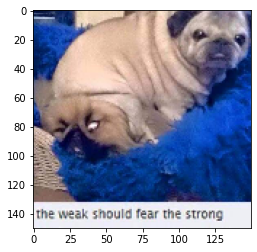

In [181]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
IMG_WIDTH, IMG_HEIGHT = 150, 150
def get_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    return img
img_path = get_image("C:/Users/User/Pictures/IMG_20200214_142028.jpg")
plt.imshow(img_path)
plt.show()

In [182]:
img_array = image.img_to_array(img_path)
img_array.shape

(150, 150, 3)

In [183]:
expanded_img_array = img_array.reshape(-1, 150, 150, 3)
expanded_img_array.shape

(1, 150, 150, 3)

In [184]:
preprocessed_img = expanded_img_array / 255. # Preprocess the image

prediction = model.predict(preprocessed_img)

print(prediction)
print(class_names)

[[0.0498057 0.9501943]]
['cat', 'dog']


In [185]:
classes={
    0: 'cat',
    1: 'dog'
}

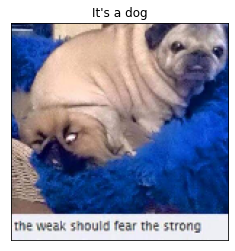

In [186]:
plt.imshow(img_path)
title=''

cat_or_dog = np.argmax(prediction)
if cat_or_dog >= .80:
    title = 'dog'
else:
    title = 'cat'

plt.title('It\'s a {}'.format(title))
plt.xticks([])
plt.yticks([]);

In [1]:
# Question 11
# Done in a seperate project in different Github Repo

# End of Notebook.